# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [2]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # Define the layers of the network
            
            # Define the Input Layer --> 1st Hidden Layer
            nn.Linear(no_features, no_hidden),  # Input layer to 1st hidden layer with 'no_features number' of input features and 'no_hidden number' of neurons
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(p=0.2),  # Applying dropout with probability 0.2

            # Define the 1st Hidden Layer --> 2nd Hidden Layer
            nn.Linear(no_hidden, no_hidden),  # 1st hidden layer to 2nd hidden layer with 'no_features number' of input features and 'no_hidden number' of neurons
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(p=0.2),  # Applying dropout with probability 0.2

            # Define the 2nd Hidden Layer --> 3rd Hidden Layer
            nn.Linear(no_hidden, no_hidden), # 2nd hidden layer to 3rd hidden layer with 'no_features number' of input features and 'no_hidden number' of neurons
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(p=0.2),  # Applying dropout with probability 0.2

            # Define the 3rd Hidden Layer --> Output Layer
            nn.Linear(no_hidden, no_labels),  # 3rd hidden layer to output layer with 'no_hidden number' of neurons and 'no_labels number' of output neurons
            nn.Sigmoid()  # Sigmoid activation function for binary classification
        )

    def forward(self, x):
        # Pass the input tensor through the layers
        return self.mlp_stack(x)

#### Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    drop_columns = ['filename', 'label']  # Columns to be dropped from the dataframe
    X_train, y_train, X_test, y_test = split_dataset(df, drop_columns, test_size=0.25, random_state=42)  # Split the dataset with test_size=0.25 to achieve 75:25 train-test ratio
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)  # Scale the input features
    return X_train_scaled, y_train, X_test_scaled, y_test


df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [4]:
# Perform data analysis to check the shape of the datasets
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Perform data analysis to check the first few rows of the datasets using the head() function
print(f"First few rows of X_train_scaled: \n{X_train_scaled[:5]}")
print(f"First few rows of y_train: \n{y_train[:5]}")
print(f"First few rows of X_test_scaled: \n{X_test_scaled[:5]}")
print(f"First few rows of y_test: \n{y_test[:5]}")

Shape of X_train_scaled: (9042, 77)
Shape of y_train: (9042,)
Shape of X_test_scaled: (3015, 77)
Shape of y_test: (3015,)
First few rows of X_train_scaled: 
[[-9.87475000e-01 -5.56427530e-01 -2.28954041e-01  6.66705518e-01
  -1.19555685e+00  1.12813472e+00  5.73816836e-02  6.67213775e-01
  -6.66625188e-01 -8.89598889e-02 -3.02143473e-01  4.87002628e-01
  -4.52667889e-01  3.99929968e-01 -5.51270359e-01  5.19944860e-03
   2.82607189e-02 -4.29347914e-01 -7.50606675e-01 -6.03245875e-01
  -8.14223081e-01 -1.24736827e+00 -2.86031463e-01 -4.20285520e-01
  -4.20285520e-01  2.31595495e-01  2.31595495e-01  6.30801950e-01
  -3.05395159e-01 -3.01282194e-01 -6.70163293e-01  4.20217280e-02
  -2.83196420e-01  2.30236363e-01  7.23586338e-02  7.72435065e-01
   9.30247197e-01  4.87234350e-01 -2.63565352e-01  9.85813670e-01
  -1.63722948e-01 -8.13352478e-01 -5.65352223e-01 -1.07263126e-01
  -4.71687613e-02  7.53691075e-01 -5.31366265e-01 -3.36243264e-01
  -6.61790180e-01  9.53315234e-02 -1.03344674e+00  

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)  # Convert the input features to PyTorch tensors with the appropriate float datatype 
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1)  # Convert the outputs to PyTorch tensors with the appropriate float datatype convert from 1D to 2D tensor

    def __len__(self):
        return len(self.y)  # Return the number of samples in the dataset

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # Return the input features and the outputs for the given index


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    batch_size = 128 # Define a variable for the specified batch size
    
    # Create a custom dataset for the training and test sets
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    # Create a DataLoader for the training and test sets
    # Shuffle the datasets to ensure that the model does not overfit to the order of the samples
    # Set the batch size to the specified batch size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_dataloader, test_dataloader


train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

In [6]:
# Analyse the sizes of the training and test dataloaders and the number of batches
print(f"Number of batches in the training dataloader: {len(train_dataloader)}")
print(f"Number of batches in the test dataloader: {len(test_dataloader)}")
# Analyse the sizes of the training and test dataloaders
print(f"Size of the training dataloader: {len(train_dataloader.dataset)}")
print(f"Size of the test dataloader: {len(test_dataloader.dataset)}")

Number of batches in the training dataloader: 71
Number of batches in the test dataloader: 24
Size of the training dataloader: 9042
Size of the test dataloader: 3015


In [7]:
# Perform data analysis to check the first few batches of the training and test dataloaders
for X_batch, y_batch in train_dataloader:
    print(f"X_batch: \n{X_batch[:5]}")  # Print the first few samples of the input features
    print(f"y_batch: \n{y_batch[:5]}")  # Print the first few samples of the outputs
    break  # Break the loop to prevent the entire dataset from being printed
    
for X_batch, y_batch in test_dataloader:
    print(f"X_batch: \n{X_batch[:5]}")  # Print the first few samples of the input features
    print(f"y_batch: \n{y_batch[:5]}")  # Print the first few samples of the outputs
    break  # Break the loop to prevent the entire dataset from being printed

X_batch: 
tensor([[ 2.2484e-01,  1.2943e+00,  1.1824e+00, -7.2890e-01,  1.1738e+00,
          4.6950e-01,  5.4496e-01,  1.0186e+00, -1.0389e+00, -5.2530e-01,
         -3.3258e-01, -3.7052e-01,  8.3651e-03, -8.3728e-02,  3.8832e-01,
         -5.3204e-01, -4.3631e-01,  2.7825e-01, -6.1142e-01,  4.8171e-01,
         -9.0796e-01,  3.5939e-01,  6.4827e-01,  4.1033e-01,  4.1033e-01,
         -5.6569e-01, -5.6569e-01, -3.6170e-01, -4.9435e-02, -1.3735e-02,
         -5.3060e-01,  4.8784e-02, -5.7047e-01,  2.2512e-01, -4.0536e-01,
         -2.9993e-01, -3.2538e-01, -1.8299e-01,  2.8634e-01, -9.0267e-01,
         -6.9109e-01,  2.1591e-02,  5.4720e-01, -3.1955e-02,  2.8295e-01,
          4.5752e-01,  1.5549e-01, -5.3664e-01, -6.6326e-01, -2.5046e-02,
          1.2598e+00, -1.4884e-01, -3.5843e-01, -5.3490e-01, -7.6097e-02,
         -1.5318e-01,  1.1235e+00,  4.9193e-01,  8.8369e-01,  5.5862e-01,
          1.7116e-01, -2.4465e-01,  6.9145e-01, -2.4838e-01,  2.0163e+00,
          3.6163e-01,  8.450

4.Next, define the model, optimizer and loss function.

In [8]:
# Define the variables specifying the model architecture
no_features = X_train_scaled.shape[1]  # Number of input features
no_hidden = 128  # Number of neurons in each hidden layer
no_labels = 1  # Number of output labels
learning_rate = 0.001  # Learning rate for the optimizer

model = MLP(no_features, no_hidden, no_labels)  # Create an instance of the MLP class
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Create an instance of the Adam optimizer
loss_fn = nn.BCELoss()  # Create an instance of the binary cross-entropy loss function

In [9]:
# Print statements to check the model architecture
print(f"The model has been defined with {no_features} input features, {no_hidden} neurons in each hidden layer and {no_labels} output labels.")
print(f"The Adam optimizer has been defined with a learning rate of {learning_rate}.")
print(f"The loss function has been defined as the binary cross-entropy loss function.")


The model has been defined with 77 input features, 128 neurons in each hidden layer and 1 output labels.
The Adam optimizer has been defined with a learning rate of 0.001.
The loss function has been defined as the binary cross-entropy loss function.


5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [10]:
from common_utils import EarlyStopper # Import the EarlyStopper class from the common_utils.py file 

# Define the specified parameters
patience = 3  # Define the patience for early stopping
no_epochs = 100  # Define the number of epochs for training

# Define the variables to store the training and test accuracies
train_accuracies = []
train_after_accuracies = []
test_accuracies = []

# Define the variables to store the training and test losses
train_losses = []
train_after_losses = []
test_losses = []

# Define the early stopping function
early_stopper = EarlyStopper(patience=patience) 

# Train the model for the specified number of epochs
for epoch in range(1, no_epochs + 1):
    # Set the model to training mode
    model.train()
    
    # Perform mini-batch gradient descent for the training dataset and compute the training accuracy and loss during the training process
    train_loss, train_accuracy = 0, 0  # Define the variables to store the training loss and accuracy
    train_no_batches = len(train_dataloader)  # Define the number of mini-batches in the training dataset
    train_size = len(train_dataloader.dataset) # Define the size of the dataset# Define the size of the dataset
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients
        y_pred = model(X_batch)  # Perform a forward pass of the model
        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model parameters
        
        # Compute the training accuracy and loss for the current batch
        train_loss += loss.item()  # Add the loss value to the running total
        train_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
    
    # Compute the average training accuracy and loss values
    train_accuracy /= train_size  # Compute the average training accuracy
    train_loss /= train_no_batches  # Compute the average training loss
    train_accuracies.append(train_accuracy)  # Append the training accuracy to the list
    train_losses.append(train_loss)  # Append the training loss to the list
    
    # Set the model to evaluation mode
    model.eval()
    # Disable gradient computation using the no_grad context, reducing memory consumption
    with torch.no_grad():
        test_loss, test_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the test dataset
        test_no_batches = len(test_dataloader)  # Define the number of mini-batches in the test dataset
        test_size = len(test_dataloader.dataset) # Define the size of the dataset
        
        # Compute the test accuracy and loss
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch)  # Perform a forward pass of the model
            loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
            
            # Compute the test accuracy and loss for the current batch
            test_loss += loss.item()  # Add the loss value to the running total
            test_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
        
        # Compute the average test and test accuracy and loss values
        test_accuracy /= test_size  # Compute the average test accuracy
        test_loss /= test_no_batches  # Compute the average test loss
        test_accuracies.append(test_accuracy)  # Append the test accuracy to the list
        test_losses.append(test_loss)  # Append the test loss to the list
        
        # Compute the training accuracy and loss for the current epoch after training for the epoch has finished
        train_after_loss, train_after_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the training dataset
        for X_batch, y_batch in train_dataloader:
            y_pred = model(X_batch)  # Perform a forward pass of the model
            loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
            
            # Compute the training accuracy and loss
            train_after_loss += loss.item()  # Add the loss value to the running total
            train_after_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
        
        # Compute the average training accuracy and loss values
        train_after_accuracy /= train_size  # Compute the average training accuracy
        train_after_loss /= train_no_batches  # Compute the average training loss
        train_after_accuracies.append(train_after_accuracy)  # Append the training accuracy to the list
        train_after_losses.append(train_after_loss)  # Append the training loss to the list
        
    # Print the training and test accuracies and losses for the current epoch
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}, Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    # Check for early stopping
    if early_stopper.early_stop(test_loss):
        print(f"Validation loss has not decreased for the last {patience} epochs. Early stopping...")
        break

Epoch 1: Train Accuracy = 0.5585, Test Accuracy = 0.5881, Train Loss = 0.6830, Test Loss = 0.6695
Epoch 2: Train Accuracy = 0.5908, Test Accuracy = 0.6106, Train Loss = 0.6673, Test Loss = 0.6546
Epoch 3: Train Accuracy = 0.6223, Test Accuracy = 0.6202, Train Loss = 0.6478, Test Loss = 0.6449
Epoch 4: Train Accuracy = 0.6429, Test Accuracy = 0.6421, Train Loss = 0.6332, Test Loss = 0.6299
Epoch 5: Train Accuracy = 0.6558, Test Accuracy = 0.6431, Train Loss = 0.6181, Test Loss = 0.6195
Epoch 6: Train Accuracy = 0.6724, Test Accuracy = 0.6637, Train Loss = 0.5995, Test Loss = 0.6079
Epoch 7: Train Accuracy = 0.6952, Test Accuracy = 0.6673, Train Loss = 0.5780, Test Loss = 0.6007
Epoch 8: Train Accuracy = 0.7048, Test Accuracy = 0.6925, Train Loss = 0.5689, Test Loss = 0.5883
Epoch 9: Train Accuracy = 0.7202, Test Accuracy = 0.7085, Train Loss = 0.5461, Test Loss = 0.5646
Epoch 10: Train Accuracy = 0.7344, Test Accuracy = 0.7038, Train Loss = 0.5273, Test Loss = 0.5713
Epoch 11: Train Acc

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


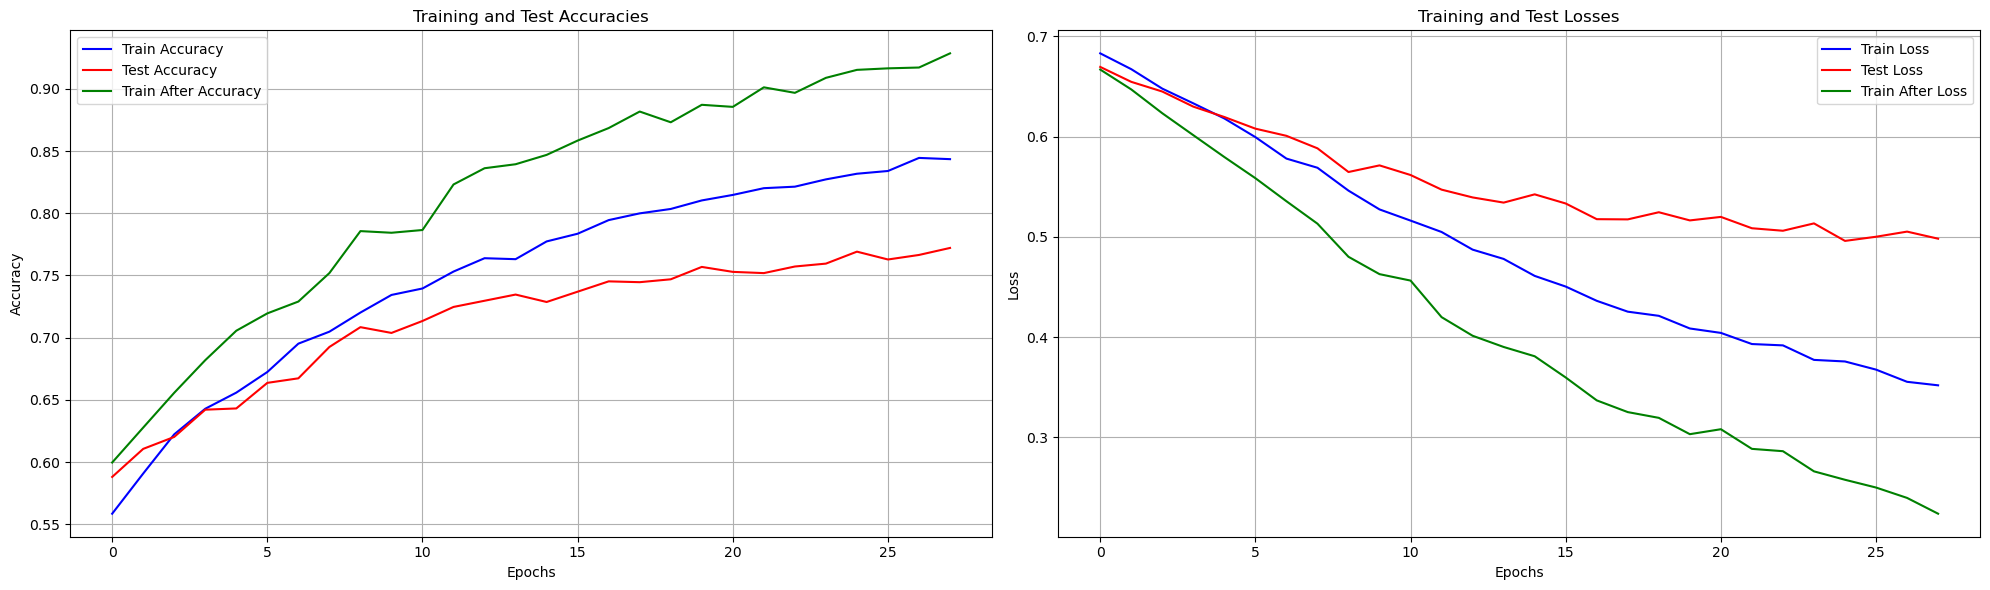

In [11]:
# Plot the training and test accuracies and losses against the training epochs
plt.figure(figsize=(20, 6))

# Plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.plot(train_after_accuracies, label='Train After Accuracy', color='green')
# Label the plot
plt.title('Training and Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.plot(train_after_losses, label='Train After Loss', color='green')
# Label the plot
plt.title('Training and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

6.Comment on line plots.

In [12]:
answer = """
As we can see from the line plots, there is a significant difference between the evaluation on the training dataset during the learning phase and after the learning phase.

1. Training (During Learning) vs Test:
- In the beginning, the test accuracy and loss is better than the training accuracy and loss. This can be explained by the fact that the evaluation on the testing data is done after the learning phase, and the model already uses the updated parameters for the evaluation. However as the training progresses, the training accuracy and loss improves as the model learns from the training data, and thus performs better than on the unseen test data.

2. Training (After Learning) vs Test:
- The training accuracy and loss on the training dataset after learning is better than the test accuracy and loss from the beginning. In the start of the learning, the two lines are quite close to each other because the model has not learned much from the training data. However, as the training progresses, the accuracy and loss for both improve, but the training accuracy and loss is always better than the test accuracy and loss. This is because the model has learned from the training data, and thus performs better on the training data than on the unseen test data.

3. Possible Future Overfriting:
- As we can see in the end of the plots, the training accuracy and loss continues to improve with high rates while the test line almost becomes flat with several slight increases. This can be a sign of overfitting, as the model is learning from the training data too much and is not generalizing well to the unseen test data. This can be a sign of overfitting, and thus the model may not perform well on unseen data.
"""